## Preliminaries


### Installations

In order to work through this notebook, you must install pyulog and pandas.

+ Install pyulog:
~~~~
sudo apt-get install python-testresources
sudo pip install pyulog
~~~~

+ Install pandas:
~~~~
sudo apt-get install python-pandas
~~~~

### Recording a flight log
A new flight log is recorded every time the flight controller is powered on (and are stored when it powered off). To record a new flight log:

+ In QGroundControl, click on the "page and magnifying glass" symbol in the top left corner. Select **Mavlink Console**.
+ To start recording a new flight log, enter `reboot` into the command terminal.
+ To stop recording, enter`reboot` into the command terminal again.
+ Flight data is logged using the .ulog file format. 

<div class="alert alert-info">
**Note:** Optical flow must be started *after* the first reboot
</div>

### Accessing a flight log
You can access your flight logs (stored as .ulg files) in `/var/lib/mavlink-router/`

### Converting .ulg file to .csv file
In this nootbook we will work with a pandas dataframe. In order to create a pandas dataframe of flight log data, we must first convert the .ulg file to .csv files (one .ulg file will be split into multiple .csv files, each containing specific flight infomation). This can be done with the following command:
~~~~
ulog2csv <your-ulg-file>.ulg
~~~~

+ The unfiltered accelorometer data is stored in the 'sensor_combined' .csv file
+ The filtered accelorometer date is stored in the 'estimator_status' .csv file

### Relationship between acceleration, velocity and position
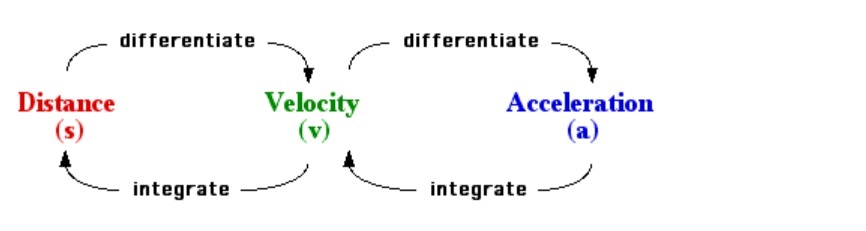

Let's see how integration works in python using constant acceleration.

## Idealized Acceleration

In [58]:
import pandas as pd
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt

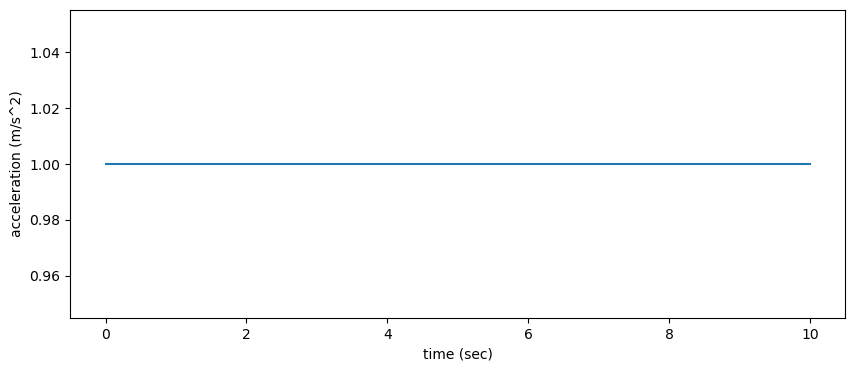

In [59]:
# Example acceleration data representing constant acceleration over a period of 10 seconds
##Just run this code
data = [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1)] # (time, accel)

times = []
accel = []
for point in data: 
    times.append(point[0])
    accel.append(point[1])
    
# Plot acceration vs. time
fig,ax = plt.subplots()
ax.plot([time for time in times], accel)
ax.set_ylabel('acceleration (m/s^2)')
ax.set_xlabel('time (sec)')
fig.set_size_inches(10,4)

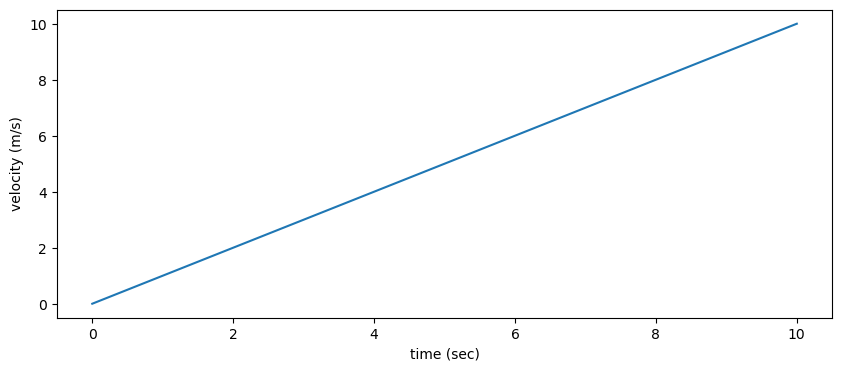

In [60]:
# Integrate acceration to get the drone's velocity at each time
##Run this code and see how integration works in python
vel = scipy.integrate.cumtrapz(accel, x = times, initial = 0)

# Plot velocity vs. time
fig,ax = plt.subplots()
ax.plot([time for time in times], vel)
ax.set_ylabel('velocity (m/s)')
ax.set_xlabel('time (sec)')
fig.set_size_inches(10,4)

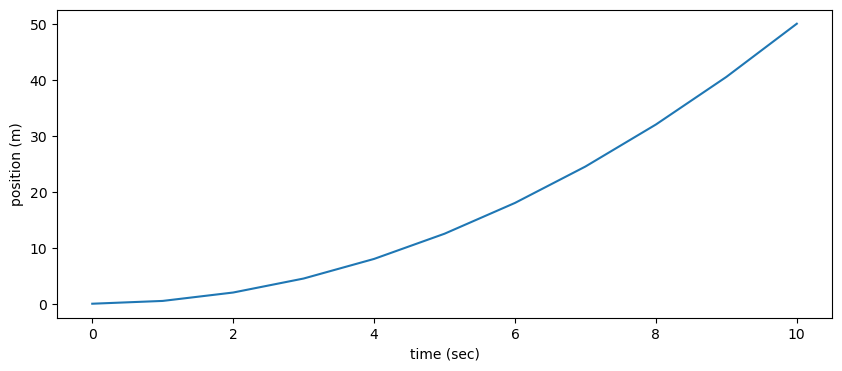

In [61]:
# Integrate velocity to get the drone's position at each time

pos = scipy.integrate.cumtrapz(vel, x = times, initial = 0)


# Plot position vs. time
fig,ax = plt.subplots()
ax.plot([time for time in times], pos)
ax.set_ylabel('position (m)')
ax.set_xlabel('time (sec)')
fig.set_size_inches(10,4)

## State estimation in UAV

You just saw how it works in python. Then, let's see how it works in measured data of the drone. 
We will fly the drone and give you flight log data(ulg) file. Your mission is analyzing the data, estimate and plot the position in x direction, then compare it to the kalman filter data.

For visual reference, here is a video of the flight from which the flight log was generated:

https://drive.google.com/file/d/1tmNqJppgiuaaBKqzV_VnTG3gkm_FK_E-/view?usp=sharing

### Load log data

The first data frame we will create contains the accelerations measured by the drone's accelerometer. The columns accelerometer_m_s2[0], accelerometer_m_s2[1], and accelerometer_m_s2[2] contain the accelerations measured in the XYZ body frame (in m/s/s).

In [62]:
# Load sensor data as a pandas data frame
##ulg file should be change to csv file using above command 
##if you change ulg file to csv file, you can see lots of csv file. Choose _-sensor_combined_0.csv to do this lab
sensor_data = pd.read_csv('accelerometer_filtering_test_flight_sensor_combined_0.csv')
sensor_data.head()

,timestamp,gyro_rad[0],gyro_rad[1],gyro_rad[2],gyro_integral_dt,accelerometer_timestamp_relative,accelerometer_m_s2[0],accelerometer_m_s2[1],accelerometer_m_s2[2],accelerometer_integral_dt
0,711784461,-0.000370,0.005919,0.000636,4000,0,0.094792,-0.005091,-9.80330,4000
1,711788460,-0.001241,0.002845,-0.000449,3999,0,0.098547,0.006911,-9.80750,3999
2,711792460,-0.001636,-0.000254,0.001223,4000,0,0.085035,-0.016474,-9.81274,4000
3,711796465,-0.000897,-0.004840,0.000949,4005,0,0.106711,-0.019402,-9.80655,4005
4,711800460,0.001670,0.004207,0.001539,3995,0,0.110271,-0.010942,-9.79505,3995


The second data frame we will create contains state estimation data that has been filtered by an algorithm called the Extended Kalman Filter (EKF). The EKF processes sensor measurements from multiple sources (IMU, magnitometer, range finder, optical flow, etc.) and blends them together to get a much more accurate estimation of the drone's state. The columns states[4], states[5], and states[6] contain the velocities in the NED frame (in m/s).

In [63]:
# Load EKF data as a pandas data frame
ekf_data = pd.read_csv('accelerometer_filtering_test_flight_estimator_status_0.csv')
ekf_data.head()

,timestamp,states[0],states[1],states[2],states[3],states[4],states[5],states[6],states[7],states[8],...,beta_test_ratio,time_slip,gps_check_fail_flags,filter_fault_flags,innovation_check_flags,solution_status_flags,nan_flags,health_flags,timeout_flags,pre_flt_fail
0,711776971,0.995747,0.014194,-0.003589,-0.090957,0.003736,-0.004825,-0.000617,0.006731,0.037672,...,0.0,0.000152,0,0,0,367,0,0,0,0
1,711976949,0.995746,0.014237,-0.003573,-0.090966,0.001190,-0.002321,-0.000805,0.006714,0.037762,...,0.0,0.000129,0,0,0,367,0,0,0,0
2,712180946,0.995746,0.014342,-0.003493,-0.090950,-0.004227,0.003577,-0.001800,0.005277,0.039316,...,0.0,0.000121,0,0,0,367,0,0,0,0
3,712385617,0.995748,0.014296,-0.003567,-0.090937,-0.002695,0.001662,-0.001577,0.005081,0.039455,...,0.0,-0.000002,0,0,0,367,0,0,0,0
4,712589645,0.995749,0.014289,-0.003642,-0.090921,0.001124,0.000372,-0.001111,0.006023,0.039308,...,0.0,0.000025,0,0,0,367,0,0,0,0


### Filter the accelerometer data

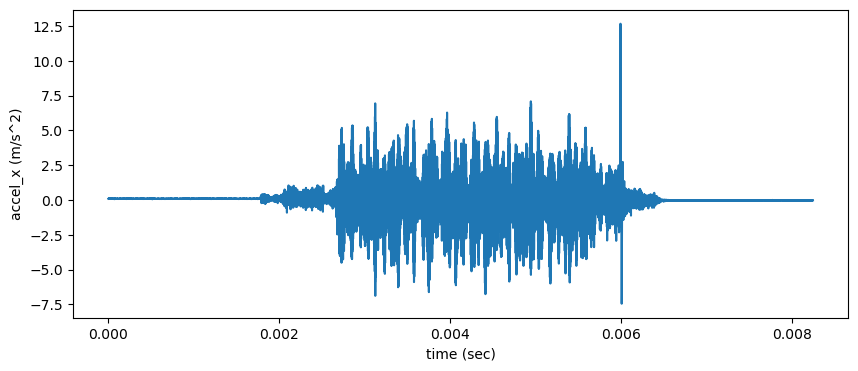

In [64]:
# Acceleration data in the XYZ body frame (m/s/s)
accel_x = sensor_data['accelerometer_m_s2[0]'].tolist()
accel_y = sensor_data['accelerometer_m_s2[1]'].tolist()
accel_z = sensor_data['accelerometer_m_s2[2]'].tolist()

def get_times(timestamps):
    """
    Given a list of timestamps (in microseconds), returns a list of times (in seconds) starting at t = 0.
    
        Args:
            - timestamps = list of timestamps (microseconds)
            
        Returns: list of times (seconds) 
    """
    start = timestamps[0]
    k = 1.0/1000000
    times = []
    for timestamp in timestamps:
        time = k * (timestamp - start)
        times.append(time)
    return times

# Convert timestamps into a list of times (in sec) starting at t = 0.
sensor_times = get_times(sensor_data.index.tolist())

# Plot acceleration vs. sensor_time (we will only plot acceleration in the x direction)
fig,ax = plt.subplots()

plt.plot(sensor_times, accel_x)

ax.set_ylabel('accel_x (m/s^2)')
ax.set_xlabel('time (sec)')
fig.set_size_inches(10,4)

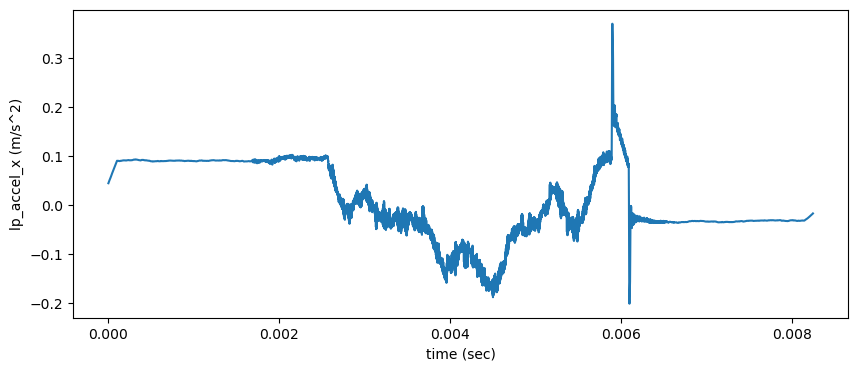

In [65]:
# Low pass filter example (not used)
def low_pass_filter(sequence, windowsize):
    positions = len(sequence) - windowsize + 1
    windows = []
    for i in range(positions):
        window = np.array(sequence[i:i+windowsize])
        mean = window.mean()
        windows.append(mean)
    return np.array(windows)

# Apply a low pass filter to the accelerometer data
windowsize = 200
lp_accel_x = np.convolve(accel_x, np.ones((windowsize,))/windowsize, mode='same')
lp_accel_y = np.convolve(accel_y, np.ones((windowsize,))/windowsize, mode='same')
lp_accel_z = np.convolve(accel_z, np.ones((windowsize,))/windowsize, mode='same')

# Plot lpf acceleration vs. time (we will only plot acceleration in the x direction)
fig,ax = plt.subplots()
ax.plot(sensor_times, lp_accel_x)
ax.set_ylabel('lp_accel_x (m/s^2)')
ax.set_xlabel('time (sec)')
fig.set_size_inches(10,4)

### Calculate change in position

With flight logs, you can estimate position by integrating acceleration. See how it looks 

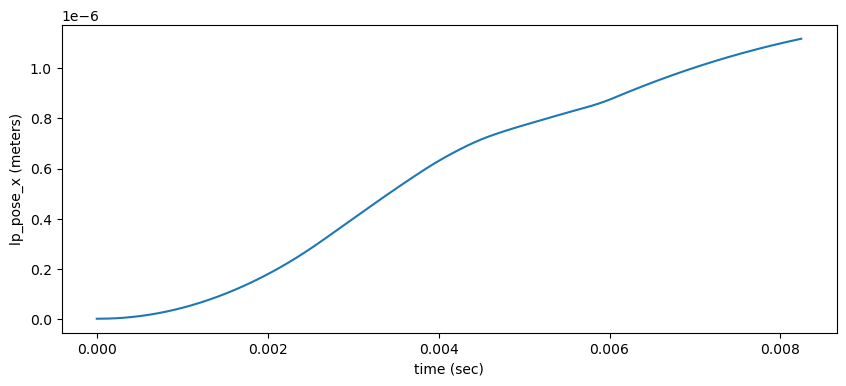

In [66]:
# Integrate acceration to get the drone's velocity at each time
vel = scipy.integrate.cumulative_trapezoid(lp_accel_x, x = sensor_times, initial = 0)

# Integrate velocity to get the drone's position at each time
lp_pos_x = scipy.integrate.cumulative_trapezoid(vel, x = sensor_times, initial = 0)

# Plot position vs. time (we will only plot acceleration in the x direction)
fig,ax = plt.subplots()
ax.plot(sensor_times, lp_pos_x)
ax.set_ylabel('lp_pose_x (meters)')
ax.set_xlabel('time (sec)')
fig.set_size_inches(10,4)

### Kalman filter
As you can see from the above result, it is quite different from what you expected. The estimated position came out to near 20 meters! To solve the problem, one answer is using Kalman filters. You can estimate your states more accurately with it. Below is some code to extract Kalman filter information that is stored during the test flight. Using this data, calculate the position again and compare with the above sensor data.

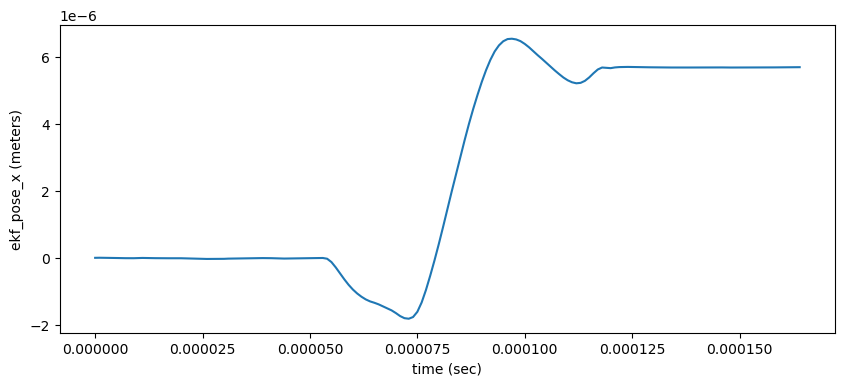

In [67]:
# EKF velocity data in the NED frame (m/s)
ekf_vel_x = ekf_data['states[4]'].tolist()
ekf_vel_y = ekf_data['states[5]'].tolist()
ekf_vel_z = ekf_data['states[6]'].tolist()

# Convert timestamps into a list of times (in sec) starting at t = 0.
ekf_times = get_times(ekf_data.index.tolist())

# Integrate EKF velocity to get the drone's position at each time
ekf_pos_est_x = scipy.integrate.cumulative_trapezoid(ekf_vel_x, x = ekf_times, initial = 0)

# Plot position vs. time (we will only plot acceleration in the x direction)
fig,ax = plt.subplots()
ax.plot(ekf_times, ekf_pos_est_x)
ax.set_ylabel('ekf_pose_x (meters)')
ax.set_xlabel('time (sec)')
fig.set_size_inches(10,4)

### Compare gained position with estimated position in karman
Actually, kalman filter data has its estimated poisition. Compare the above data you got from integrating acceleration with the data in kalman filter. (state[7] indicates the position estimation from the kalman filter)

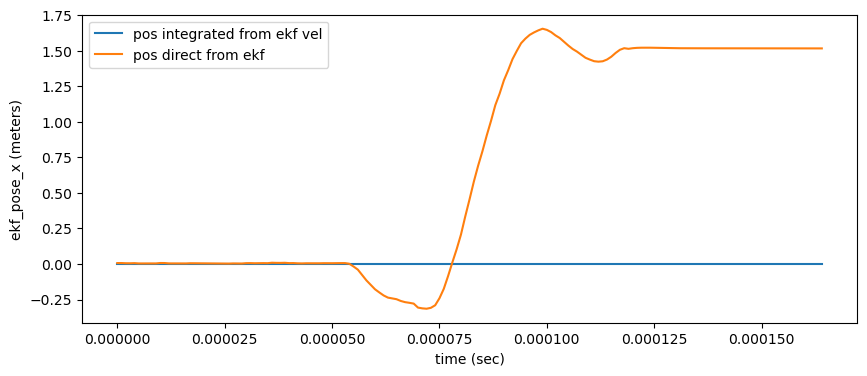

In [68]:
# EKF position data in the NED frame (m/s)
ekf_pos_x = ekf_data['states[7]'].tolist()
ekf_pos_y = ekf_data['states[8]'].tolist()
ekf_pos_z = ekf_data['states[9]'].tolist()

# Plot position vs. time (we will only plot acceleration in the x direction)
fig,ax = plt.subplots()
ax.plot([time for time in ekf_times], ekf_pos_est_x, [time for time in ekf_times], ekf_pos_x,)
ax.set_ylabel('ekf_pose_x (meters)')
ax.set_xlabel('time (sec)')
ax.legend(['pos integrated from ekf vel', 'pos direct from ekf'])
fig.set_size_inches(10,4)